<a href="https://colab.research.google.com/github/ccsed/ProgettoLabAI/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collego colab a google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [89]:
import os

def conta_file(directory):
    try:

        elementi = os.listdir(directory)

        file = [f for f in elementi if os.path.isfile(os.path.join(directory, f))]

        numero_file = len(file)
        return numero_file
    except Exception as e:
        print(f"Errore: {e}")
        return 0

directory_path = '/content/Labels'
print(f"Numero di file nella directory: {conta_file(directory_path)}")


Numero di file nella directory: 3401


Importo le librerie necessarie

In [90]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 58.1 MB/s eta 0:00:00


In [91]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import random
import skimage.io as io
from rasterio.plot import show
import torch.nn as nn
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm
import torchvision
from osgeo import gdal
import cv2
import tifffile as tiff
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

Definisco alcune directory

In [92]:
drive_dir = '/content/drive/MyDrive'
image_dir = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity'
train_path = '/content/drive/MyDrive/train.txt'
val_path = '/content/drive/MyDrive/val.txt'
test_path = '/content/drive/MyDrive/test.txt'

Media e std calcolate in Funzioni.ipynb

In [93]:
# mean = [22.79312241, 24.30391245, 19.29892107, 17.69439361]
# std = [16.42519281, 17.42876255, 14.27711349, 13.24714869]
mean = [0.0, 0.0, 0.0, 0.0]
std = [1.0, 1.0, 1.0, 1.0]

Definiamo la classe SARDataset

In [94]:
# class SARDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, transform=None):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         mask_path = self.mask_paths[idx]


#         with rasterio.open(image_path) as src:
#             image = src.read().transpose((1, 2, 0))
#             # print(image.shape)
#             image = image.astype(np.float32)

#         with rasterio.open(mask_path) as src:
#             mask = src.read(1).astype(np.float32)
#             # print(mask.shape)
#             mask[mask == 255.0] = 1.0


#         if self.transform is not None:
#             augmentations = self.transform(image=image, mask=mask)
#             image = augmentations["image"]
#             mask = augmentations["mask"]

#         return image, mask
class SARDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            image = image.astype(np.float32)

            mean = [22.79312241, 24.30391245, 19.29892107, 17.69439361]
            std = [16.42519281, 17.42876255, 14.27711349, 13.24714869]
            image = (image - mean) / std

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)
            mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


Carico i percorsi delle immagini per il training, il validation e il test set

In [95]:
with open(train_path, 'r') as f:
    train_data = [line.split() for line in f.read().splitlines()]

train_image_paths = [line[0] for line in train_data]
train_label_paths = ['/' + line[1] for line in train_data]

with open(val_path, 'r') as f:
    val_data = [line.split() for line in f.read().splitlines()]

val_image_paths = [line[0] for line in val_data]
val_label_paths = ['/' + line[1] for line in val_data]

with open(test_path, 'r') as f:
    test_data = [line.split() for line in f.read().splitlines()]

test_image_paths = [line[0] for line in test_data]
test_label_paths = ['/' + line[1] for line in test_data]

Creo il modello UNET

Classe DoubleConv

In [96]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)



Classe UNET

In [97]:
class UNET(nn.Module):
  def __init__(
      self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
  ):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2,
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

Seed

In [98]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

Funzione per il training

In [99]:
def train_fn(loader, model, optimizer, loss_fn, scaler, txtfile):
    loop = tqdm(loader)
    tot_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.float().to(device=device)

        with torch.cuda.amp.autocast():
            predictions = model(data).squeeze(1)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        tot_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = tot_loss / len(loader)
    with open(txtfile, "a") as f:
        f.write(f"Train Loss: {avg_loss:.4f}\n")


Utils

In [100]:
def save_checkpoint(state, filename="/content/drive/MyDrive/model1/checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

Evaluation function

In [101]:
def eval_fn(loader, model, loss_fn, txtfile, device="cuda"):
    model.eval()
    num_correct = 0
    num_pixels = 0
    total_dice_score = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_loss = 0

    with torch.no_grad():
        for num_it, (x, y) in enumerate(loader, start=1):
            print(num_it)
            x = x.to(device)
            y = y.to(device)
            out = model(x).squeeze(1)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            preds = torch.sigmoid(out)
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

            dice_score = (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            total_dice_score += dice_score.item()

            y_np = y.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            total_precision += precision_score(y_np, preds_np, zero_division=1)
            total_recall += recall_score(y_np, preds_np, zero_division=1)
            total_f1 += f1_score(y_np, preds_np, zero_division=1)

    avg_loss = total_loss / len(loader)
    avg_dice_score = total_dice_score / len(loader)
    avg_precision = total_precision / len(loader)
    avg_recall = total_recall / len(loader)
    avg_f1 = total_f1 / len(loader)
    accuracy = num_correct / num_pixels * 100

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Dice score: {avg_dice_score:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

    with open(txtfile, "a") as f:
        f.write(f"Validation Loss: {avg_loss:.4f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Dice score: {avg_dice_score:.4f}\n")
        f.write(f"Precision: {avg_precision:.4f}\n")
        f.write(f"Recall: {avg_recall:.4f}\n")
        f.write(f"F1 Score: {avg_f1:.4f}\n")
        f.write("\n")

    model.train()
    return avg_loss, accuracy, avg_dice_score, avg_precision, avg_recall, avg_f1

In [102]:
def save_predictions_as_imgs(loader, model, folder, device="cuda"):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    it = 1
    for idx, (x, y) in enumerate(tqdm(loader, desc="Saving predictions")):
        print(it)
        it += 1
        x = x.to(device=device)
        y = y.to(device=device).unsqueeze(1)

        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        combined = torch.cat((y, preds), dim=2)
        torchvision.utils.save_image(combined, f"{folder}/comparison_{idx}.png")

    model.train()


Training baseline

In [103]:
set_seed(42)

transform = A.Compose([
    A.Resize(height=320, width=320),
    # A.CenterCrop(height=896, width=896),
    # A.RandomCrop(height=320, width=320),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1),
    # A.Rotate(limit=90, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=320, width=320),
    # A.CenterCrop(height=896, width=896),
    # A.RandomCrop(height=320, width=320),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.Rotate(limit=90, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

train_dataset = SARDataset(train_image_paths, train_label_paths, transform=transform)
val_dataset = SARDataset(val_image_paths, val_label_paths, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
load_model = False
lr = 1e-4
model_dir = "/content/drive/MyDrive/model11"
step_size = 45

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channels=4, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size)
num_epochs = 50
scaler = torch.cuda.amp.GradScaler()

if load_model:
  load_checkpoint(torch.load(model_dir + "/checkpoint.pth.tar"), model)



In [75]:
best_f1_score = 0.0

In [76]:


for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    train_fn(train_loader, model, optimizer, criterion, scaler, model_dir + "/output/output.txt")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, model_dir + "/checkpoint.pth.tar")

    val_loss, val_accuracy, val_dice_score, val_precision, val_recall, val_f1 = eval_fn(val_loader, model, criterion, model_dir + "/output/output.txt", device=device)

    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        save_checkpoint(checkpoint, filename=os.path.join(model_dir, "best_model.pth.tar"))
        print(f"New best F1 score: {best_f1_score:.4f}")

    if (epoch + 1) % 5 == 0:
        save_predictions_as_imgs(val_loader, model, model_dir + "/images/", device=device)

    scheduler.step()


epoch 0


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.278]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.3070
Accuracy: 92.75
Dice score: 0.1534
Precision: 0.4477
Recall: 0.0941
F1 Score: 0.1534
=> Saving checkpoint
New best F1 score: 0.1534
epoch 1


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.244]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.2612
Accuracy: 92.67
Dice score: 0.1507
Precision: 0.4265
Recall: 0.0935
F1 Score: 0.1507
epoch 2


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.205]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.2354
Accuracy: 92.91
Dice score: 0.0184
Precision: 0.6174
Recall: 0.0094
F1 Score: 0.0184
epoch 3


100%|██████████| 149/149 [01:38<00:00,  1.51it/s, loss=0.234]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.2407
Accuracy: 92.71
Dice score: 0.2786
Precision: 0.4630
Recall: 0.2023
F1 Score: 0.2786
=> Saving checkpoint
New best F1 score: 0.2786
epoch 4


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.193]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.2274
Accuracy: 92.37
Dice score: 0.3457
Precision: 0.4359
Recall: 0.2916
F1 Score: 0.3457
=> Saving checkpoint
New best F1 score: 0.3457


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:02<01:27,  2.07s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:50,  1.22s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:37,  1.05it/s]

4


Saving predictions:   9%|▉         | 4/43 [00:03<00:32,  1.21it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:28,  1.31it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:26,  1.38it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:05<00:25,  1.44it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:23,  1.47it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:22,  1.48it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:07<00:21,  1.50it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:21,  1.51it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:20,  1.52it/s]

13


Saving predictions:  30%|███       | 13/43 [00:09<00:19,  1.53it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:18,  1.55it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:11<00:18,  1.55it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:11<00:17,  1.54it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:16,  1.55it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:12<00:16,  1.56it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:13<00:15,  1.56it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:14,  1.55it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:14<00:14,  1.55it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.55it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.55it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:16<00:12,  1.56it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.57it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:10,  1.55it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:18<00:10,  1.56it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.56it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:20<00:08,  1.57it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:20<00:08,  1.56it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.55it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:21<00:07,  1.56it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.58it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.58it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:23<00:05,  1.58it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.59it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:25<00:03,  1.59it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:25<00:03,  1.59it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.59it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:27<00:01,  1.59it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:27<00:01,  1.59it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.59it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:28<00:00,  1.50it/s]


epoch 5


100%|██████████| 149/149 [01:46<00:00,  1.40it/s, loss=0.18]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1953
Accuracy: 93.18
Dice score: 0.1709
Precision: 0.6210
Recall: 0.1007
F1 Score: 0.1709
epoch 6


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.192]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1868
Accuracy: 93.24
Dice score: 0.1921
Precision: 0.6263
Recall: 0.1154
F1 Score: 0.1921
epoch 7


100%|██████████| 149/149 [01:43<00:00,  1.44it/s, loss=0.197]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1835
Accuracy: 92.96
Dice score: 0.3758
Precision: 0.5003
Recall: 0.3067
F1 Score: 0.3758
=> Saving checkpoint
New best F1 score: 0.3758
epoch 8


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.159]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1833
Accuracy: 93.24
Dice score: 0.1916
Precision: 0.6346
Recall: 0.1154
F1 Score: 0.1916
epoch 9


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.139]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1736
Accuracy: 93.34
Dice score: 0.2776
Precision: 0.5908
Recall: 0.1844
F1 Score: 0.2776


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:05<04:08,  5.93s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:06<01:57,  2.86s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:07<01:15,  1.88s/it]

4


Saving predictions:   9%|▉         | 4/43 [00:08<00:55,  1.42s/it]

5


Saving predictions:  12%|█▏        | 5/43 [00:08<00:43,  1.15s/it]

6


Saving predictions:  14%|█▍        | 6/43 [00:09<00:36,  1.01it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:10<00:32,  1.10it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:10<00:29,  1.19it/s]

9


Saving predictions:  21%|██        | 9/43 [00:11<00:27,  1.21it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:12<00:25,  1.29it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:12<00:23,  1.34it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:13<00:22,  1.40it/s]

13


Saving predictions:  30%|███       | 13/43 [00:14<00:20,  1.45it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:14<00:19,  1.49it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:15<00:18,  1.52it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:16<00:17,  1.53it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:16<00:16,  1.57it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:17<00:15,  1.57it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:17<00:15,  1.60it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:18<00:14,  1.61it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:19<00:14,  1.56it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:19<00:13,  1.59it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:20<00:12,  1.59it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:21<00:11,  1.59it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:21<00:11,  1.60it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:22<00:10,  1.58it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:23<00:10,  1.58it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:23<00:09,  1.57it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:24<00:08,  1.60it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:24<00:08,  1.59it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:25<00:07,  1.59it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:26<00:06,  1.57it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:26<00:06,  1.57it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:27<00:05,  1.57it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:28<00:05,  1.58it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:28<00:04,  1.58it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:29<00:03,  1.60it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:29<00:03,  1.61it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:30<00:02,  1.61it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:31<00:01,  1.61it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:31<00:01,  1.60it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:32<00:00,  1.61it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:32<00:00,  1.31it/s]


epoch 10


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.148]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1683
Accuracy: 93.48
Dice score: 0.3243
Precision: 0.6116
Recall: 0.2253
F1 Score: 0.3243
epoch 11


100%|██████████| 149/149 [01:40<00:00,  1.48it/s, loss=0.129]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1717
Accuracy: 93.35
Dice score: 0.2040
Precision: 0.6859
Recall: 0.1216
F1 Score: 0.2040
epoch 12


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.128]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1658
Accuracy: 93.45
Dice score: 0.2315
Precision: 0.6930
Recall: 0.1416
F1 Score: 0.2315
epoch 13


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.183]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1606
Accuracy: 93.63
Dice score: 0.3370
Precision: 0.6392
Recall: 0.2351
F1 Score: 0.3370
epoch 14


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.202]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1539
Accuracy: 93.80
Dice score: 0.3820
Precision: 0.6475
Recall: 0.2755
F1 Score: 0.3820
=> Saving checkpoint
New best F1 score: 0.3820


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:02<01:38,  2.35s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:55,  1.35s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:40,  1.01s/it]

4


Saving predictions:   9%|▉         | 4/43 [00:04<00:33,  1.17it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:29,  1.27it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:27,  1.35it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:06<00:25,  1.41it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:24,  1.44it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:23,  1.47it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:08<00:22,  1.49it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:20,  1.53it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:19,  1.56it/s]

13


Saving predictions:  30%|███       | 13/43 [00:09<00:18,  1.59it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:18,  1.61it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:11<00:17,  1.59it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:11<00:16,  1.61it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:16,  1.59it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:13<00:15,  1.57it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:13<00:15,  1.56it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:14,  1.54it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:15<00:14,  1.55it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.55it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.55it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:17<00:12,  1.55it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.58it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:10,  1.56it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:18<00:10,  1.56it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.58it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:20<00:08,  1.60it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:20<00:08,  1.59it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.58it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:22<00:06,  1.59it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.59it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.58it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:23<00:05,  1.58it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.59it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:25<00:03,  1.60it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:25<00:03,  1.60it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.59it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:27<00:01,  1.62it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:27<00:01,  1.61it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.60it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:28<00:00,  1.50it/s]


epoch 15


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.207]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1577
Accuracy: 93.75
Dice score: 0.3462
Precision: 0.6625
Recall: 0.2384
F1 Score: 0.3462
epoch 16


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.143]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1523
Accuracy: 93.60
Dice score: 0.4966
Precision: 0.5557
Recall: 0.4538
F1 Score: 0.4966
=> Saving checkpoint
New best F1 score: 0.4966
epoch 17


100%|██████████| 149/149 [01:40<00:00,  1.48it/s, loss=0.12]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1567
Accuracy: 93.73
Dice score: 0.4852
Precision: 0.5746
Recall: 0.4236
F1 Score: 0.4852
epoch 18


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.126]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1437
Accuracy: 94.07
Dice score: 0.4096
Precision: 0.6866
Recall: 0.2955
F1 Score: 0.4096
epoch 19


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.174]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1477
Accuracy: 94.07
Dice score: 0.4178
Precision: 0.6755
Recall: 0.3091
F1 Score: 0.4178


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:02<01:28,  2.10s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:51,  1.25s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:38,  1.03it/s]

4


Saving predictions:   9%|▉         | 4/43 [00:04<00:33,  1.17it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:29,  1.28it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:27,  1.36it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:06<00:25,  1.41it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:23,  1.47it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:22,  1.49it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:07<00:21,  1.53it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:20,  1.57it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:22,  1.40it/s]

13


Saving predictions:  30%|███       | 13/43 [00:10<00:20,  1.46it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:21,  1.37it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:11<00:19,  1.43it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:12<00:18,  1.48it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:17,  1.50it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:13<00:16,  1.53it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:14<00:15,  1.55it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:14,  1.56it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:15<00:13,  1.58it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.60it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.60it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:17<00:11,  1.60it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.60it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:10,  1.56it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:19<00:10,  1.55it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.55it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:20<00:08,  1.56it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:20<00:08,  1.58it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.58it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:22<00:06,  1.59it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.59it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.59it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:24<00:05,  1.60it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.59it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:25<00:03,  1.60it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:25<00:03,  1.59it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.59it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:27<00:01,  1.61it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:27<00:01,  1.60it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.60it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:28<00:00,  1.49it/s]


epoch 20


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.156]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1458
Accuracy: 93.94
Dice score: 0.4899
Precision: 0.6008
Recall: 0.4197
F1 Score: 0.4899
epoch 21


100%|██████████| 149/149 [01:40<00:00,  1.48it/s, loss=0.116]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1375
Accuracy: 94.30
Dice score: 0.5163
Precision: 0.6391
Recall: 0.4365
F1 Score: 0.5163
=> Saving checkpoint
New best F1 score: 0.5163
epoch 22


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.124]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1349
Accuracy: 94.45
Dice score: 0.4876
Precision: 0.6971
Recall: 0.3786
F1 Score: 0.4876
epoch 23


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.139]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1643
Accuracy: 94.02
Dice score: 0.3599
Precision: 0.7342
Recall: 0.2437
F1 Score: 0.3599
epoch 24


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.129]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1365
Accuracy: 94.41
Dice score: 0.4520
Precision: 0.7409
Recall: 0.3282
F1 Score: 0.4520


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:01<01:20,  1.91s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:47,  1.16s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:37,  1.07it/s]

4


Saving predictions:   9%|▉         | 4/43 [00:03<00:31,  1.22it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:28,  1.32it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:26,  1.38it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:05<00:25,  1.42it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:23,  1.47it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:22,  1.49it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:07<00:21,  1.50it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:21,  1.52it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:20,  1.54it/s]

13


Saving predictions:  30%|███       | 13/43 [00:09<00:19,  1.51it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:19,  1.46it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:11<00:18,  1.50it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:11<00:17,  1.52it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:17,  1.52it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:13<00:16,  1.54it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:13<00:15,  1.55it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:14,  1.56it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:14<00:13,  1.57it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.58it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.58it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:16<00:12,  1.57it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.58it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:10,  1.56it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:18<00:10,  1.57it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.58it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:19<00:08,  1.59it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:20<00:08,  1.57it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.58it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:21<00:06,  1.60it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.61it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.60it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:23<00:05,  1.59it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.60it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:24<00:03,  1.60it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:25<00:03,  1.61it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.60it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:26<00:01,  1.61it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:27<00:01,  1.60it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.60it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:28<00:00,  1.51it/s]


epoch 25


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.138]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1614
Accuracy: 93.81
Dice score: 0.3185
Precision: 0.7330
Recall: 0.2068
F1 Score: 0.3185
epoch 26


100%|██████████| 149/149 [01:40<00:00,  1.48it/s, loss=0.111]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1704
Accuracy: 92.98
Dice score: 0.4156
Precision: 0.5066
Recall: 0.3591
F1 Score: 0.4156
epoch 27


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.152]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1263
Accuracy: 94.87
Dice score: 0.5540
Precision: 0.7135
Recall: 0.4558
F1 Score: 0.5540
=> Saving checkpoint
New best F1 score: 0.5540
epoch 28


100%|██████████| 149/149 [01:40<00:00,  1.48it/s, loss=0.106]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1253
Accuracy: 94.82
Dice score: 0.5691
Precision: 0.6853
Recall: 0.4896
F1 Score: 0.5691
=> Saving checkpoint
New best F1 score: 0.5691
epoch 29


100%|██████████| 149/149 [01:40<00:00,  1.48it/s, loss=0.113]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1703
Accuracy: 92.23
Dice score: 0.5010
Precision: 0.4549
Recall: 0.5647
F1 Score: 0.5010


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:02<01:32,  2.20s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:52,  1.27s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:39,  1.02it/s]

4


Saving predictions:   9%|▉         | 4/43 [00:04<00:32,  1.18it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:29,  1.29it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:27,  1.35it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:06<00:25,  1.41it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:24,  1.45it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:23,  1.48it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:08<00:22,  1.49it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:21,  1.49it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:21,  1.43it/s]

13


Saving predictions:  30%|███       | 13/43 [00:10<00:20,  1.44it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:19,  1.48it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:11<00:18,  1.50it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:12<00:17,  1.51it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:17,  1.52it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:13<00:16,  1.52it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:14<00:15,  1.53it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:14,  1.54it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:15<00:14,  1.56it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.56it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.56it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:17<00:12,  1.56it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.58it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:10,  1.56it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:19<00:10,  1.55it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.55it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:20<00:09,  1.55it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:21<00:08,  1.55it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.55it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:22<00:07,  1.56it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.58it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.60it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:24<00:05,  1.59it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.61it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:25<00:03,  1.60it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:26<00:03,  1.59it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.56it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:27<00:01,  1.56it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:28<00:01,  1.56it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.57it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:29<00:00,  1.48it/s]


epoch 30


100%|██████████| 149/149 [01:40<00:00,  1.48it/s, loss=0.118]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1206
Accuracy: 94.94
Dice score: 0.5308
Precision: 0.7707
Recall: 0.4073
F1 Score: 0.5308
epoch 31


100%|██████████| 149/149 [01:40<00:00,  1.48it/s, loss=0.093]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1247
Accuracy: 94.74
Dice score: 0.5749
Precision: 0.6647
Recall: 0.5084
F1 Score: 0.5749
=> Saving checkpoint
New best F1 score: 0.5749
epoch 32


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.0839]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1284
Accuracy: 94.74
Dice score: 0.5503
Precision: 0.6921
Recall: 0.4591
F1 Score: 0.5503
epoch 33


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.123]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1193
Accuracy: 95.09
Dice score: 0.5707
Precision: 0.7414
Recall: 0.4669
F1 Score: 0.5707
epoch 34


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.133]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1206
Accuracy: 94.86
Dice score: 0.6255
Precision: 0.6424
Recall: 0.6115
F1 Score: 0.6255
=> Saving checkpoint
New best F1 score: 0.6255


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:02<01:24,  2.01s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:50,  1.23s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:38,  1.05it/s]

4


Saving predictions:   9%|▉         | 4/43 [00:03<00:32,  1.20it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:29,  1.30it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:26,  1.38it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:05<00:25,  1.44it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:24,  1.46it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:22,  1.48it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:07<00:22,  1.48it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:21,  1.47it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:20,  1.49it/s]

13


Saving predictions:  30%|███       | 13/43 [00:09<00:19,  1.51it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:19,  1.51it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:11<00:18,  1.52it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:11<00:17,  1.55it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:16,  1.56it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:13<00:16,  1.55it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:13<00:15,  1.54it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:14,  1.54it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:15<00:14,  1.55it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.55it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.58it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:16<00:11,  1.60it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.59it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:10,  1.59it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:18<00:10,  1.59it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.58it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:20<00:08,  1.57it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:20<00:08,  1.55it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.55it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:21<00:06,  1.58it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.59it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.57it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:23<00:05,  1.59it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.59it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:25<00:03,  1.58it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:25<00:03,  1.59it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.60it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:27<00:01,  1.60it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:27<00:01,  1.59it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.59it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:28<00:00,  1.50it/s]


epoch 35


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.0917]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1181
Accuracy: 95.13
Dice score: 0.5770
Precision: 0.7440
Recall: 0.4752
F1 Score: 0.5770
epoch 36


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.134]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1202
Accuracy: 94.92
Dice score: 0.5018
Precision: 0.8136
Recall: 0.3655
F1 Score: 0.5018
epoch 37


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.122]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1181
Accuracy: 95.18
Dice score: 0.5778
Precision: 0.7519
Recall: 0.4712
F1 Score: 0.5778
epoch 38


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.187]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1227
Accuracy: 94.89
Dice score: 0.5382
Precision: 0.7405
Recall: 0.4249
F1 Score: 0.5382
epoch 39


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.131]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1165
Accuracy: 95.23
Dice score: 0.5977
Precision: 0.7314
Recall: 0.5085
F1 Score: 0.5977


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:01<01:23,  1.99s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:49,  1.20s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:37,  1.06it/s]

4


Saving predictions:   9%|▉         | 4/43 [00:03<00:32,  1.22it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:28,  1.32it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:26,  1.39it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:05<00:25,  1.44it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:23,  1.48it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:22,  1.50it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:07<00:21,  1.52it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:20,  1.56it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:20,  1.54it/s]

13


Saving predictions:  30%|███       | 13/43 [00:09<00:19,  1.56it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:18,  1.56it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:10<00:18,  1.55it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:11<00:17,  1.56it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:16,  1.56it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:12<00:15,  1.58it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:13<00:15,  1.57it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:14,  1.57it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:14<00:14,  1.55it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.55it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.55it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:16<00:12,  1.55it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.56it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:10,  1.55it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:18<00:10,  1.55it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.55it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:19<00:08,  1.56it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:20<00:08,  1.55it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.55it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:21<00:06,  1.58it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.57it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.57it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:23<00:05,  1.57it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.57it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:25<00:03,  1.56it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:25<00:03,  1.56it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.48it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:27<00:01,  1.51it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:27<00:01,  1.54it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.58it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:28<00:00,  1.50it/s]


epoch 40


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.112]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1311
Accuracy: 94.73
Dice score: 0.4834
Precision: 0.7960
Recall: 0.3492
F1 Score: 0.4834
epoch 41


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.0911]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1126
Accuracy: 95.35
Dice score: 0.6085
Precision: 0.7470
Recall: 0.5159
F1 Score: 0.6085
epoch 42


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.12]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1185
Accuracy: 95.25
Dice score: 0.6233
Precision: 0.6985
Recall: 0.5649
F1 Score: 0.6233
epoch 43


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.114]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1089
Accuracy: 95.51
Dice score: 0.6201
Precision: 0.7651
Recall: 0.5244
F1 Score: 0.6201
epoch 44


100%|██████████| 149/149 [01:39<00:00,  1.50it/s, loss=0.122]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1069
Accuracy: 95.56
Dice score: 0.6281
Precision: 0.7626
Recall: 0.5360
F1 Score: 0.6281
=> Saving checkpoint
New best F1 score: 0.6281


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:02<01:29,  2.12s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:51,  1.26s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:40,  1.00s/it]

4


Saving predictions:   9%|▉         | 4/43 [00:04<00:33,  1.16it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:29,  1.28it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:27,  1.36it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:06<00:25,  1.42it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:23,  1.46it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:22,  1.49it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:07<00:21,  1.51it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:20,  1.54it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:20,  1.54it/s]

13


Saving predictions:  30%|███       | 13/43 [00:09<00:19,  1.57it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:18,  1.57it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:11<00:18,  1.55it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:11<00:17,  1.54it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:16,  1.54it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:13<00:16,  1.54it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:13<00:15,  1.55it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:14,  1.57it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:14<00:13,  1.59it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.60it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.57it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:16<00:12,  1.56it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.56it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:11,  1.54it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:18<00:10,  1.55it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.55it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:20<00:09,  1.55it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:20<00:08,  1.55it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.55it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:22<00:07,  1.56it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.55it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.56it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:23<00:05,  1.58it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.59it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:25<00:03,  1.59it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:25<00:03,  1.59it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.59it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:27<00:01,  1.58it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:27<00:01,  1.58it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.61it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:28<00:00,  1.49it/s]


epoch 45


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.083]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1021
Accuracy: 95.79
Dice score: 0.6486
Precision: 0.7839
Recall: 0.5552
F1 Score: 0.6486
=> Saving checkpoint
New best F1 score: 0.6486
epoch 46


100%|██████████| 149/149 [01:39<00:00,  1.49it/s, loss=0.0989]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1012
Accuracy: 95.83
Dice score: 0.6652
Precision: 0.7636
Recall: 0.5913
F1 Score: 0.6652
=> Saving checkpoint
New best F1 score: 0.6652
epoch 47


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.0687]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1012
Accuracy: 95.82
Dice score: 0.6596
Precision: 0.7714
Recall: 0.5779
F1 Score: 0.6596
epoch 48


100%|██████████| 149/149 [01:40<00:00,  1.49it/s, loss=0.176]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1010
Accuracy: 95.84
Dice score: 0.6613
Precision: 0.7736
Recall: 0.5796
F1 Score: 0.6613
epoch 49


100%|██████████| 149/149 [01:40<00:00,  1.48it/s, loss=0.0707]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Validation Loss: 0.1008
Accuracy: 95.82
Dice score: 0.6669
Precision: 0.7592
Recall: 0.5964
F1 Score: 0.6669
=> Saving checkpoint
New best F1 score: 0.6669


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:02<01:33,  2.22s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:53,  1.30s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:39,  1.01it/s]

4


Saving predictions:   9%|▉         | 4/43 [00:04<00:33,  1.17it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:29,  1.28it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:27,  1.35it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:06<00:25,  1.41it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:24,  1.41it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:23,  1.46it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:08<00:22,  1.49it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:21,  1.50it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:20,  1.54it/s]

13


Saving predictions:  30%|███       | 13/43 [00:09<00:19,  1.55it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:18,  1.56it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:11<00:18,  1.55it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:11<00:17,  1.56it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:16,  1.55it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:13<00:16,  1.54it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:13<00:15,  1.53it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:14,  1.56it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:15<00:14,  1.54it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.53it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.54it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:17<00:12,  1.54it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.55it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:11,  1.52it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:19<00:10,  1.54it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.52it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:20<00:09,  1.54it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:21<00:08,  1.55it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.55it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:22<00:07,  1.56it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.56it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.57it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:24<00:05,  1.58it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.59it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:25<00:03,  1.61it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:25<00:03,  1.62it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.60it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:27<00:01,  1.58it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:27<00:01,  1.58it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.57it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:29<00:00,  1.48it/s]


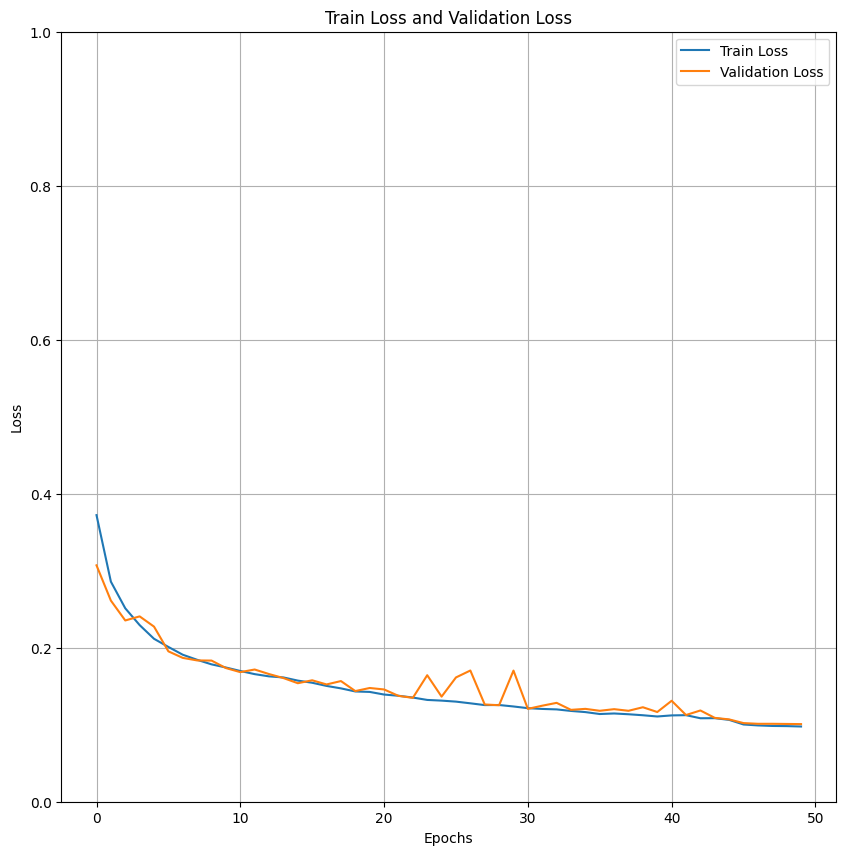

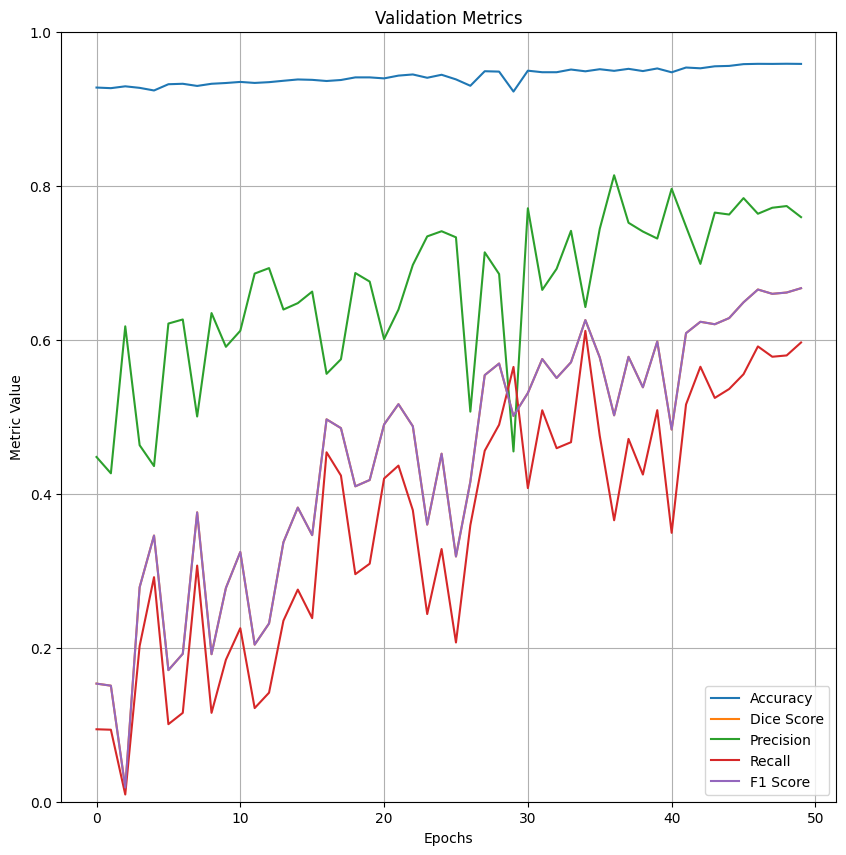

In [104]:


def read_metrics(filename):
    with open(filename, "r") as file:
        lines = file.readlines()

    metrics = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "accuracy": [],
        "dice_score": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    epoch = 0
    for line in lines:
        line = line.strip()
        if line.startswith("Train Loss:"):
            metrics["epoch"].append(epoch)
            metrics["train_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Validation Loss:"):
            metrics["val_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Accuracy:"):
            metrics["accuracy"].append(float(line.split(":")[1].strip())/100)
        elif line.startswith("Dice score:"):
            metrics["dice_score"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Precision:"):
            metrics["precision"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Recall:"):
            metrics["recall"].append(float(line.split(":")[1].strip()))
        elif line.startswith("F1 Score:"):
            metrics["f1_score"].append(float(line.split(":")[1].strip()))
            epoch += 1

    return metrics

def plot_metrics(metrics, save_dir=None):
    epochs = metrics["epoch"]

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, metrics["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    if save_dir:
        plt.savefig(os.path.join(save_dir, "loss_plot.png"))
    else:
        plt.show()

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["dice_score"], label="Dice Score")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.title("Validation Metrics")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    if save_dir:
        plt.savefig(os.path.join(save_dir, "metrics_plot.png"))
    else:
        plt.show()

metrics = read_metrics(model_dir + "/output/output.txt")
save_directory = model_dir + "/grafici"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
plot_metrics(metrics, save_dir=save_directory)
